In [2]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imread
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import glob
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
from math import sqrt
import math
import scipy
import scipy.ndimage
from skimage.morphology import skeletonize as skelt
from skimage.morphology import thin

####  Only 2000 images out of the 4000 images available in the NIST-4 database were used due to system constraints. These results wont be as accurate as the results mentioned in the research papers due to less data being used.

---

# Pre-Processing step functions

### Normalization

In [8]:
def normalize_pixel(x, v0, v, m, m0):
    """
    From Handbook of Fingerprint Recognition pg 133
    Normalize job used by Hong, Wan and Jain(1998)
    similar to https://pdfs.semanticscholar.org/6e86/1d0b58bdf7e2e2bb0ecbf274cee6974fe13f.pdf equation 21
    :param x: pixel value
    :param v0: desired variance
    :param v: global image variance
    :param m: global image mean
    :param m0: desired mean
    :return: normilized pixel
    """
    dev_coeff = sqrt((v0 * ((x - m)**2)) / v)
    return m0 + dev_coeff if x > m else m0 - dev_coeff

def normalize(im, m0, v0):
    m = np.mean(im)
    v = np.std(im) ** 2
    (y, x) = im.shape
    normilize_image = im.copy()
    for i in range(x):
        for j in range(y):
            normilize_image[j, i] = normalize_pixel(im[j, i], v0, v, m, m0)

    return normilize_image

### Segmentation

In [9]:
def normalise(img):
    return (img - np.mean(img))/(np.std(img))


def create_segmented_and_variance_images(im, w, threshold=.2):
    """
    Returns mask identifying the ROI. Calculates the standard deviation in each image block and threshold the ROI
    It also normalises the intesity values of
    the image so that the ridge regions have zero mean, unit standard
    deviation.
    :param im: Image
    :param w: size of the block
    :param threshold: std threshold
    :return: segmented_image
    """
    (y, x) = im.shape
    threshold = np.std(im)*threshold

    image_variance = np.zeros(im.shape)
    segmented_image = im.copy()
    mask = np.ones_like(im)

    for i in range(0, x, w):
        for j in range(0, y, w):
            box = [i, j, min(i + w, x), min(j + w, y)]
            block_stddev = np.std(im[box[1]:box[3], box[0]:box[2]])
            image_variance[box[1]:box[3], box[0]:box[2]] = block_stddev

    # apply threshold
    mask[image_variance < threshold] = 0

    # smooth mask with a open/close morphological filter
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(w*2, w*2))
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel)
    mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel)

    # normalize segmented image
    segmented_image *= mask
    im = normalise(im)
    mean_val = np.mean(im[mask==0])
    std_val = np.std(im[mask==0])
    norm_img = (im - mean_val)/(std_val)

    return segmented_image, norm_img, mask

### Orientation Map

In [10]:
def calculate_angles(im, W, smoth=False):
    """
    anisotropy orientation estimate, based on equations 5 from:
    https://pdfs.semanticscholar.org/6e86/1d0b58bdf7e2e2bb0ecbf274cee6974fe13f.pdf
    :param im:
    :param W: int width of the ridge
    :return: array
    """
    j1 = lambda x, y: 2 * x * y
    j2 = lambda x, y: x ** 2 - y ** 2
    j3 = lambda x, y: x ** 2 + y ** 2

    (y, x) = im.shape

    sobelOperator = [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]
    ySobel = np.array(sobelOperator).astype(np.int)
    xSobel = np.transpose(ySobel).astype(np.int)

    result = [[] for i in range(1, y, W)]

    Gx_ = cv.filter2D(im/125,-1, ySobel)*125
    Gy_ = cv.filter2D(im/125,-1, xSobel)*125

    for j in range(1, y, W):
        for i in range(1, x, W):
            nominator = 0
            denominator = 0
            for l in range(j, min(j + W, y - 1)):
                for k in range(i, min(i + W , x - 1)):
                    Gx = round(Gx_[l, k])  # horizontal gradients at l, k
                    Gy = round(Gy_[l, k])  # vertial gradients at l, k
                    nominator += j1(Gx, Gy)
                    denominator += j2(Gx, Gy)

            # nominator = round(np.sum(Gy_[j:min(j + W, y - 1), i:min(i + W , x - 1)]))
            # denominator = round(np.sum(Gx_[j:min(j + W, y - 1), i:min(i + W , x - 1)]))
            if nominator or denominator:
                angle = (math.pi + math.atan2(nominator, denominator)) / 2
                orientation = np.pi/2 + math.atan2(nominator,denominator)/2
                result[int((j-1) // W)].append(angle)
            else:
                result[int((j-1) // W)].append(0)

            # segment image
            # focus_img = im[j:min(j + W, y - 1), i:min(i + W , x - 1)]
            # segmentator = -1 if segmentator/W*W < np.max(focus_img)*

    result = np.array(result)

    if smoth:
        result = smooth_angles(result)

    return result


def gauss(x, y):
    ssigma = 1.0
    return (1 / (2 * math.pi * ssigma)) * math.exp(-(x * x + y * y) / (2 * ssigma))


def kernel_from_function(size, f):
    kernel = [[] for i in range(0, size)]
    for i in range(0, size):
        for j in range(0, size):
            kernel[i].append(f(i - size / 2, j - size / 2))
    return kernel


def smooth_angles(angles):
    """
    reference: https://airccj.org/CSCP/vol7/csit76809.pdf pg91
    Practically, it is possible to have a block so noisy that the directional estimate is completely false.
    This then causes a very large angular variation between two adjacent blocks. However, a
    fingerprint has some directional continuity, such a variation between two adjacent blocks is then
    representative of a bad estimate. To eliminate such discontinuities, a low-pass filter is applied to
    the directional board.
    :param angles:
    :return:
    """
    angles = np.array(angles)
    cos_angles = np.cos(angles.copy()*2)
    sin_angles = np.sin(angles.copy()*2)

    kernel = np.array(kernel_from_function(5, gauss))

    cos_angles = cv.filter2D(cos_angles/125,-1, kernel)*125
    sin_angles = cv.filter2D(sin_angles/125,-1, kernel)*125
    smooth_angles = np.arctan2(sin_angles, cos_angles)/2

    return smooth_angles


def get_line_ends(i, j, W, tang):
    if -1 <= tang and tang <= 1:
        begin = (i, int((-W/2) * tang + j + W/2))
        end = (i + W, int((W/2) * tang + j + W/2))
    else:
        begin = (int(i + W/2 + W/(2 * tang)), j + W//2)
        end = (int(i + W/2 - W/(2 * tang)), j - W//2)
    return (begin, end)


def visualize_angles(im, mask, angles, W):
    (y, x) = im.shape
    result = cv.cvtColor(np.zeros(im.shape, np.uint8), cv.COLOR_GRAY2RGB)
    mask_threshold = (W-1)**2
    for i in range(1, x, W):
        for j in range(1, y, W):
            radian = np.sum(mask[j - 1:j + W, i-1:i+W])
            if radian > mask_threshold:
                tang = math.tan(angles[(j - 1) // W][(i - 1) // W])
                (begin, end) = get_line_ends(i, j, W, tang)
                cv.line(result, begin, end, color=150)

    cv.resize(result, im.shape, result)
    return result

---

### Importing Data

In [6]:
image_files = glob.glob1('D:/college/Research/NIST/Biometrics-Project-main/png_txt/half_data', '*.png')

X_cnn_im,y_cnn_im = [], []
dir = 'D:/college/Research/NIST/Biometrics-Project-main/png_txt/half_data/'
for image in sorted(image_files):

  X_cnn_im.append(plt.imread(dir+image))
  y_cnn_im.append(str(image[0]))

### Preprocessing Pipeline

In [11]:
X_orient = []
for input_img in X_cnn_im:
  normalized_img = normalize(input_img.copy(), float(100), float(100))

  # ROI and normalisation
  (segmented_img, normim, mask) = create_segmented_and_variance_images(normalized_img, 16, 0.2)

  # orientations
  angles = calculate_angles(normalized_img, W=16, smoth=False)
  orientation_img = visualize_angles(segmented_img, mask, angles, W=16)

  X_orient.append(orientation_img)

C:\Users\91704\AppData\Local\Temp\ipykernel_19144\1413609433.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ySobel = np.array(sobelOperator).astype(np.int)
C:\Users\91704\AppData\Local\Temp\ipykernel_19144\1413609433.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check th

In [12]:
# label encoding the classes
y_cnn = np.array(y_cnn_im)
import sklearn
from sklearn.preprocessing import LabelEncoder
encde=LabelEncoder()
y_encode=encde.fit_transform(y_cnn)

---

# FCTP-Net Model

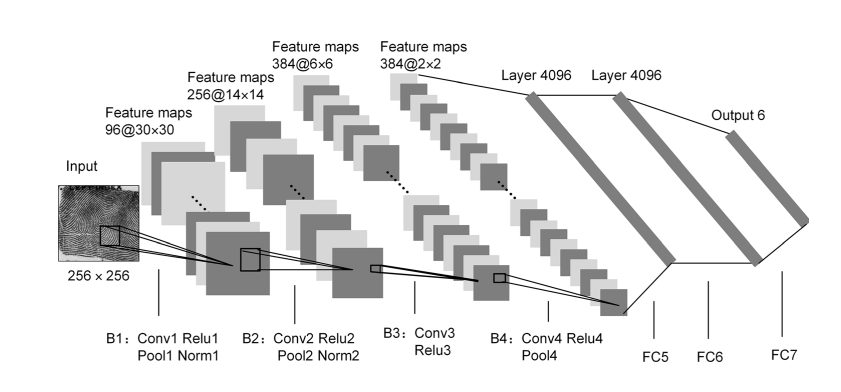

### Splitting the data

In [8]:
# resizing the images for AlexNet
X_fctp = []
for image in X_orient:
    X_fctp.append(cv.resize(image, (256,256)))

# converting to numpy array
X_fctp = np.array(X_fctp)

In [9]:
X_train_fctp, X_test_fctp, y_train_fctp, y_test_fctp = train_test_split(X_fctp, y_encode, test_size=0.25, random_state=42)

### Building and training the FCTP-Net architecture

In [10]:
model_fctp = keras.Sequential()

model_fctp.add(layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(256,256,3)))
model_fctp.add(layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model_fctp.add(layers.Lambda(tf.nn.local_response_normalization))

model_fctp.add(layers.Conv2D(filters=256, kernel_size=(5,5), activation='relu'))
model_fctp.add(layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model_fctp.add(layers.Lambda(tf.nn.local_response_normalization))

model_fctp.add(layers.Conv2D(filters=384, kernel_size=(3,3), activation='relu'))
model_fctp.add(layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model_fctp.add(layers.Lambda(tf.nn.local_response_normalization))

model_fctp.add(layers.Conv2D(filters=384, kernel_size=(2,2), activation='relu'))
model_fctp.add(layers.MaxPooling2D(pool_size=(2,2)))
model_fctp.add(layers.Lambda(tf.nn.local_response_normalization))

model_fctp.add(layers.Flatten())

model_fctp.add(layers.Dense(units=4096, activation='relu'))
model_fctp.add(layers.Dropout(0.2))
model_fctp.add(layers.Dense(units=4096, activation='relu'))
model_fctp.add(layers.Dropout(0.2))
model_fctp.add(layers.Dense(units=5, activation='softmax'))

model_fctp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 96)       0         
 )                                                               
                                                                 
 lambda (Lambda)             (None, 30, 30, 96)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 256)      0         
 2D)                                                             
                                                                 
 lambda_1 (Lambda)           (None, 12, 12, 256)       0

In [11]:
# learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.00001,
    decay_steps=2,
    decay_rate=0.5)
opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

model_fctp.compile(loss=keras.metrics.sparse_categorical_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

In [12]:
with tf.device('/GPU:0'):
    history_fctp = model_fctp.fit(X_train_fctp, y_train_fctp, batch_size=32, epochs=40, validation_split=0.15, verbose=1)

Epoch 1/50
40/40 [==============================] - 13s 116ms/step - loss: 1.5601 - accuracy: 0.2682 - val_loss: 1.3291 - val_accuracy: 0.3778
Epoch 2/50
40/40 [==============================] - 3s 80ms/step - loss: 1.2451 - accuracy: 0.4471 - val_loss: 1.1410 - val_accuracy: 0.4756
Epoch 3/50
40/40 [==============================] - 3s 80ms/step - loss: 1.0718 - accuracy: 0.5129 - val_loss: 0.9081 - val_accuracy: 0.6400
Epoch 4/50
40/40 [==============================] - 3s 80ms/step - loss: 0.8161 - accuracy: 0.6800 - val_loss: 0.6398 - val_accuracy: 0.7467
Epoch 5/50
40/40 [==============================] - 3s 80ms/step - loss: 0.5982 - accuracy: 0.7584 - val_loss: 0.5143 - val_accuracy: 0.7822
Epoch 6/50
40/40 [==============================] - 3s 80ms/step - loss: 0.5307 - accuracy: 0.7859 - val_loss: 0.4787 - val_accuracy: 0.8089
Epoch 7/50
40/40 [==============================] - 3s 80ms/step - loss: 0.4114 - accuracy: 0.8455 - val_loss: 0.4120 - val_accuracy: 0.8400
Epoch 8/50


In [13]:
print('test loss, test accuracy: ', model_fctp.evaluate(X_test_fctp, y_test_fctp))

16/16 [==============================] - 1s 61ms/step - loss: 1.0113 - accuracy: 0.8260
test loss, test accuracy:  [1.0113335847854614, 0.8259999752044678]


### FCTP-Net Training Visualisation 

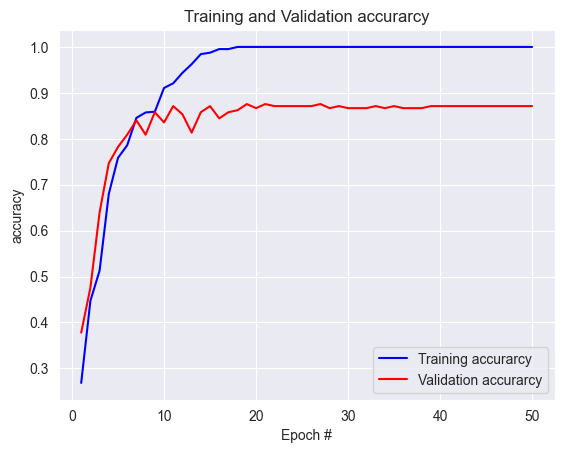

In [18]:
sns.set_style("darkgrid")

#get the details form the history object which has the training results
acc = history_fctp.history['accuracy']
val_acc = history_fctp.history['val_accuracy']
loss = history_fctp.history['loss']
val_loss = history_fctp.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.xlabel('Epoch #')
plt.ylabel('accuracy')
plt.title('Training and Validation accurarcy')
plt.legend()

---

# VGG-19 Model

### Splitting the data

In [13]:
# resizing the images for AlexNet
X_res = []
for image in X_orient:
    X_res.append(cv.resize(image, (224,224)))

# converting to numpy array
X_res = np.array(X_res)

In [14]:
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_encode, test_size=0.25, random_state=42)

### Building and training the VGG-19 architecture

In [15]:
from keras.applications.vgg19 import VGG19
with tf.device('/CPU'):
    base_model = VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False)
    base_model.trainable = False #freeze the layers

    model_vgg = tf.keras.Sequential([
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(2048, activation='relu', name='HiddenLayer-1'),
        tf.keras.layers.Dense(5, activation='softmax', name='OutputLayer')
      ])
    model_vgg.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 HiddenLayer-1 (Dense)       (None, 2048)              51382272  
                                                                 
 OutputLayer (Dense)         (None, 5)                 10245     
                                                                 
Total params: 71,416,901
Trainable params: 51,392,517
Non-trainable params: 20,024,384
_________________________________________________________________


In [16]:
model_vgg.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics = ['accuracy'])

In [20]:
with tf.device('/GPU:0'):
    history_vgg = model_vgg.fit(X_train_res, y_train_res, batch_size=32, epochs=25, validation_split=0.15, verbose=1)

Epoch 1/25
40/40 [==============================] - 40s 751ms/step - loss: 1.0190 - accuracy: 0.7106 - val_loss: 1.1335 - val_accuracy: 0.6800
Epoch 2/25
40/40 [==============================] - 22s 548ms/step - loss: 0.2440 - accuracy: 0.9200 - val_loss: 0.9428 - val_accuracy: 0.6844
Epoch 3/25
40/40 [==============================] - 22s 558ms/step - loss: 0.0723 - accuracy: 0.9890 - val_loss: 0.9328 - val_accuracy: 0.7067
Epoch 4/25
40/40 [==============================] - 22s 547ms/step - loss: 0.0306 - accuracy: 0.9992 - val_loss: 0.9684 - val_accuracy: 0.6889
Epoch 5/25
40/40 [==============================] - 22s 548ms/step - loss: 0.0185 - accuracy: 1.0000 - val_loss: 0.9329 - val_accuracy: 0.7156
Epoch 6/25
40/40 [==============================] - 22s 555ms/step - loss: 0.0123 - accuracy: 1.0000 - val_loss: 0.9489 - val_accuracy: 0.7067
Epoch 7/25
40/40 [==============================] - 22s 549ms/step - loss: 0.0097 - accuracy: 1.0000 - val_loss: 0.9390 - val_accuracy: 0.7156

In [23]:
print('test loss, test accuracy: ', model_vgg.evaluate(X_test_res, y_test_res))

16/16 [==============================] - 11s 725ms/step - loss: 1.0198 - accuracy: 0.7120
test loss, test accuracy:  [1.0198469161987305, 0.7120000123977661]


### VGG-19 Training Visualisation

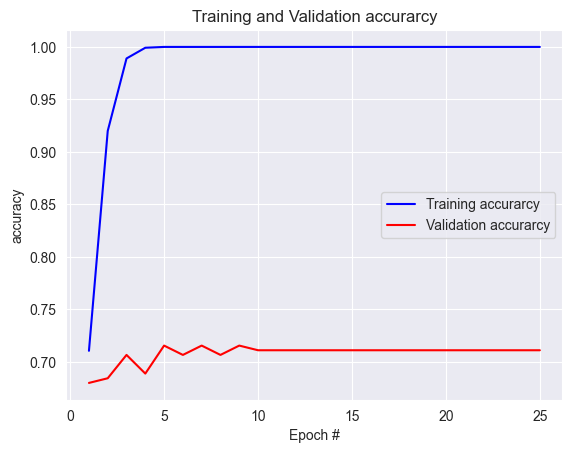

In [24]:
sns.set_style("darkgrid")

#get the details form the history object which has the training results
acc = history_vgg.history['accuracy']
val_acc = history_vgg.history['val_accuracy']
loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.xlabel('Epoch #')
plt.ylabel('accuracy')
plt.title('Training and Validation accurarcy')
plt.legend()

---

# CaffeNet Model

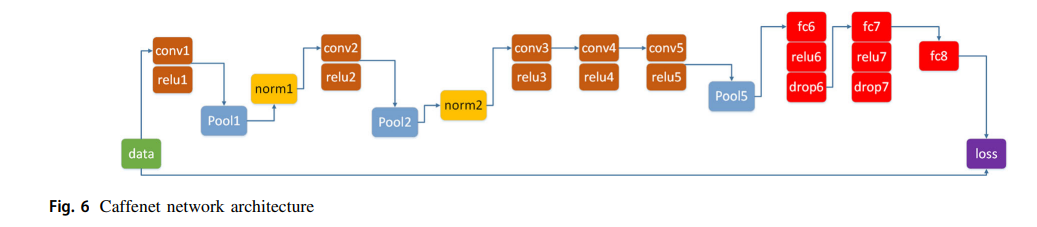

### Building and training the CaffeNet architecture

In [29]:
model_caffe = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(5, activation='softmax')
])

model_caffe.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 26, 26, 96)       0         
 g2D)                                                            
                                                                 
 batch_normalization_10 (Bat  (None, 26, 26, 96)       384       
 chNormalization)                                                
                                                                 
 conv2d_11 (Conv2D)          (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 12, 12, 256)      0         
 g2D)                                                            
                                                      

In [30]:
model_caffe.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics = ['accuracy'])

In [31]:
with tf.device('/GPU:0'):
    history_caffe = model_caffe.fit(X_train_res, y_train_res, batch_size=16, epochs=20, validation_split=0.15, verbose=1)

Epoch 1/20
80/80 [==============================] - 9s 63ms/step - loss: 2.7590 - accuracy: 0.3843 - val_loss: 2.8188 - val_accuracy: 0.2311
Epoch 2/20
80/80 [==============================] - 4s 49ms/step - loss: 0.9133 - accuracy: 0.6714 - val_loss: 1.0260 - val_accuracy: 0.5644
Epoch 3/20
80/80 [==============================] - 4s 49ms/step - loss: 0.4592 - accuracy: 0.8267 - val_loss: 1.0310 - val_accuracy: 0.6178
Epoch 4/20
80/80 [==============================] - 4s 50ms/step - loss: 0.2832 - accuracy: 0.9004 - val_loss: 0.9892 - val_accuracy: 0.7067
Epoch 5/20
80/80 [==============================] - 4s 49ms/step - loss: 0.1147 - accuracy: 0.9608 - val_loss: 1.3240 - val_accuracy: 0.6267
Epoch 6/20
80/80 [==============================] - 4s 49ms/step - loss: 0.1494 - accuracy: 0.9545 - val_loss: 1.2238 - val_accuracy: 0.6933
Epoch 7/20
80/80 [==============================] - 4s 51ms/step - loss: 0.0712 - accuracy: 0.9757 - val_loss: 1.2464 - val_accuracy: 0.7422
Epoch 8/20
80

In [32]:
print('test loss, test accuracy: ', model_caffe.evaluate(X_test_res, y_test_res))

16/16 [==============================] - 2s 64ms/step - loss: 1.6657 - accuracy: 0.7100
test loss, test accuracy:  [1.6656819581985474, 0.7099999785423279]


### CaffeNet Training Visualisation

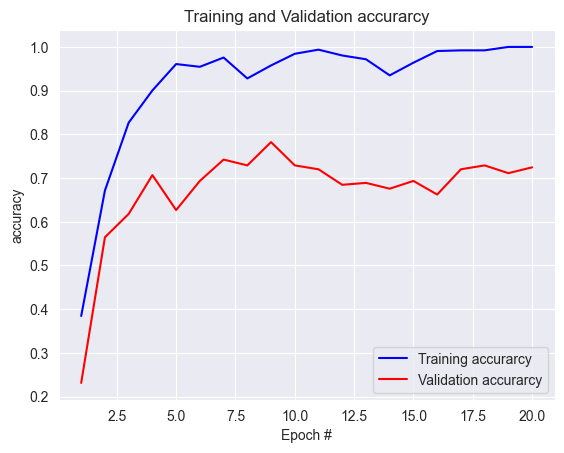

In [33]:
sns.set_style("darkgrid")

#get the details form the history object which has the training results
acc = history_caffe.history['accuracy']
val_acc = history_caffe.history['val_accuracy']
loss = history_caffe.history['loss']
val_loss = history_caffe.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.xlabel('Epoch #')
plt.ylabel('accuracy')
plt.title('Training and Validation accurarcy')
plt.legend()

---

# VGG-F Model

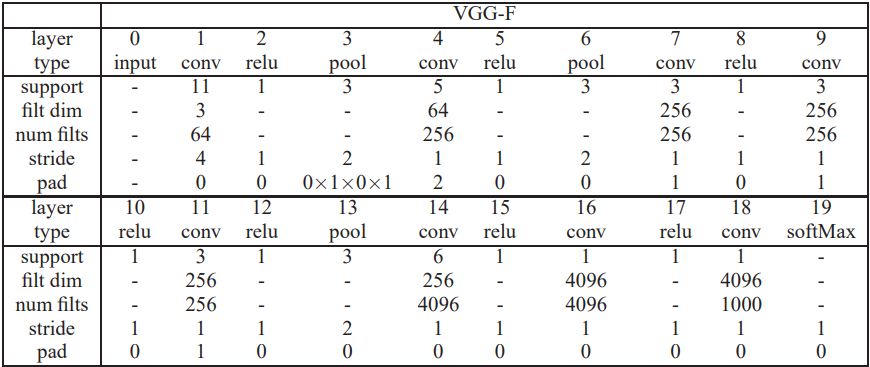

### Building and training the VGG-F Model

In [15]:
with tf.device('/CPU'):
    model_f = keras.Sequential()

    model_f.add(layers.Conv2D(filters=64, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)))
    model_f.add(layers.BatchNormalization())
    model_f.add(layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)))

    model_f.add(layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='valid', activation='relu'))
    model_f.add(layers.BatchNormalization())
    model_f.add(layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)))

    model_f.add(layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
    model_f.add(layers.BatchNormalization())

    model_f.add(layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
    model_f.add(layers.BatchNormalization())

    model_f.add(layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
    model_f.add(layers.BatchNormalization())
    model_f.add(layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)))

    model_f.add(layers.Flatten())

    model_f.add(layers.Dense(units=4096, activation='relu'))
    model_f.add(layers.Dropout(0.2))

    model_f.add(layers.Dense(units=4096, activation='relu'))
    model_f.add(layers.Dropout(0.2))

    model_f.add(layers.Dense(units=5, activation='softmax'))

    model_f.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 64)        23296     
                                                                 
 batch_normalization (BatchN  (None, 54, 54, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 256)       409856    
                                                                 
 batch_normalization_1 (Batc  (None, 22, 22, 256)      1024      
 hNormalization)                                                 
                                                        

In [16]:
model_f.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics = ['accuracy'])

In [24]:
with tf.device('/GPU:0'):
    history_f = model_f.fit(X_train_res, y_train_res, batch_size=16, epochs20, validation_split=0.15, verbose=1)

Epoch 1/20
80/80 [==============================] - 14s 174ms/step - loss: 0.0546 - accuracy: 0.9820 - val_loss: 2.8991 - val_accuracy: 0.6400
Epoch 2/20
80/80 [==============================] - 14s 173ms/step - loss: 0.0714 - accuracy: 0.9851 - val_loss: 2.3528 - val_accuracy: 0.6400
Epoch 3/20
80/80 [==============================] - 14s 173ms/step - loss: 0.0346 - accuracy: 0.9898 - val_loss: 2.7739 - val_accuracy: 0.5733
Epoch 4/20
80/80 [==============================] - 14s 173ms/step - loss: 0.0285 - accuracy: 0.9890 - val_loss: 4.0854 - val_accuracy: 0.6000
Epoch 5/20
80/80 [==============================] - 14s 173ms/step - loss: 0.0567 - accuracy: 0.9890 - val_loss: 1.6796 - val_accuracy: 0.7022
Epoch 6/20
80/80 [==============================] - 14s 173ms/step - loss: 0.0142 - accuracy: 0.9953 - val_loss: 2.1972 - val_accuracy: 0.7111
Epoch 7/20
80/80 [==============================] - 14s 174ms/step - loss: 0.0200 - accuracy: 0.9945 - val_loss: 1.8432 - val_accuracy: 0.7022

In [25]:
print('test loss, test accuracy: ', model_f.evaluate(X_test_res, y_test_res))

16/16 [==============================] - 1s 53ms/step - loss: 2.2547 - accuracy: 0.7120
test loss, test accuracy:  [2.2546818256378174, 0.7120000123977661]


### VGG-F Training Visualisation

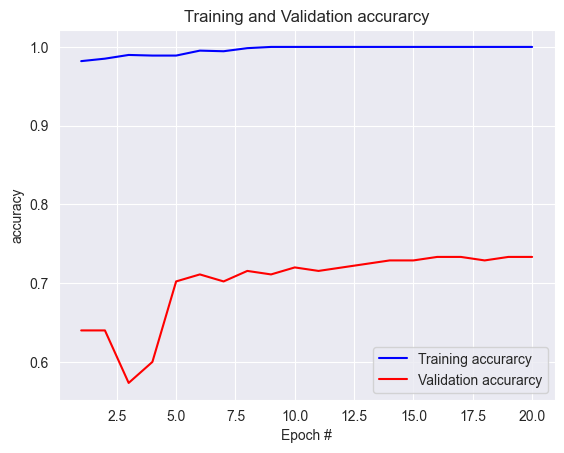

In [27]:
sns.set_style("darkgrid")

#get the details form the history object which has the training results
acc = history_f.history['accuracy']
val_acc = history_f.history['val_accuracy']
loss = history_f.history['loss']
val_loss = history_f.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.xlabel('Epoch #')
plt.ylabel('accuracy')
plt.title('Training and Validation accurarcy')
plt.legend()

---

## Results:
### - FCTP-Net: Accuracy = 82.6%; Loss = 1.01
### - VGG-19: Accuracy = 71.2%; Loss = 1.02
### - CaffeNet: Accuracy = 71%; Loss = 1.66
### - VGG-F: Accuracy = 71.2%; Loss = 2.25

### When we compare these models to the previous architectures, it is evident that the performance has improved and the classification is more accurate.
### A common drawback of all our models is that they overfit. This problem can likely be solved by providing more data. We could not train the models on the complete NIST-4 dataset due to system constraints.
### FCTP-Net is our best model in terms of performance as it gives us the highest accuracy and shows less overfitting compared to the other 3 architectures.
### FCTP-Net architecture was mentioned in the [Fingerprint pattern identification and classification approach based on convolutional neural networks](https://link.springer.com/article/10.1007/s00521-019-04499-w) paper and performed very well when trained on the entire dataset(4000 images) for 100,000 epochs.
### Other changes that could help improve the performance of these architectures would be to adopt a different optimizers and check for the accuracy.

---